In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import sklearn 
import random
from sklearn.ensemble import RandomForestClassifier
from typing import Sequence, Tuple

In [2]:
meteo = np.load('/home/u108-n256/PalmProject/NeuralNetwork_Testing/NN_Inputs/SMSE/RAW_Meteorological_Data.npy')
pheno = np.load('/home/u108-n256/PalmProject/NeuralNetwork_Testing/NN_Inputs/SMSE/RAW_Phenological_Data.npy')

In [3]:
# Define the number of points in the kernel and standard deviation
import scipy.stats


kernel_size = 17  # Number of points in the kernel (should be odd to have a center point)
std_dev = 2  # Standard deviation, controls the spread of the Gaussian curve

# Generate a linspace array centered at 0 (kernel will be symmetrical around 0)
x_values = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)

# Compute the Gaussian kernel using the normal distribution's PDF
gaussian_kernel = scipy.stats.norm.pdf(x_values, loc=0, scale=std_dev)

# Normalize the kernel to have the highest value as 1 (optional, but useful)
gaussian_kernel /= gaussian_kernel.max()

print(gaussian_kernel)

[3.35462628e-04 2.18749112e-03 1.11089965e-02 4.39369336e-02
 1.35335283e-01 3.24652467e-01 6.06530660e-01 8.82496903e-01
 1.00000000e+00 8.82496903e-01 6.06530660e-01 3.24652467e-01
 1.35335283e-01 4.39369336e-02 1.11089965e-02 2.18749112e-03
 3.35462628e-04]


In [4]:
columns = ['RankOneLeafDate','AppearedSpatheDate_compl','OpenedSpatheDate_compl','FloweringDate_compl','HarvestDate_compl','BunchMass','FemaleInflo','MaleInflo','AbortedInflo','BunchLoad']
pheno = [pd.DataFrame(pheno[i], columns=columns) for i in range(len(pheno))]

# for p in pheno:
#     p['FemaleInflo_r'] = p['FemaleInflo'].rolling(window=17,center=True).apply(lambda x: np.sum(x*gaussian_kernel), raw=True).fillna(0)
#     p['MaleInflo_r'] = p['MaleInflo'].rolling(window=17,center=True).apply(lambda x: np.sum(x*gaussian_kernel), raw=True).fillna(0)

for p in pheno:
    p['FemaleInflo_r'] = p['FemaleInflo'].rolling(window=40,center=True).apply(lambda x: np.mean(x) if np.any(x > 0) else 0, raw=True).fillna(0)
    p['MaleInflo_r'] = p['MaleInflo'].rolling(window=40,center=True).apply(lambda x: np.mean(x) if np.any(x > 0) else 0, raw=True).fillna(0)


columns=['TMin', 'TMax', 'TAverage', 'HRMin', 'HRMax', 'HRAverage', 'WindSpeed', 'Rainfall','Rg']
meteo = pd.DataFrame(meteo, columns=columns)

In [5]:
meteo_features = {i : f'{name}' for i, name in enumerate(meteo.columns)}
meteo = meteo.to_numpy()

In [6]:
pheno_features = {i : f'{name}' for i, name in enumerate(pheno[0].columns)}
pheno = np.concatenate([p.to_numpy().reshape(1,-1,12) for p in pheno],axis=0)

In [7]:
extreme_quantiles = np.zeros((4,9))

# {0:'low', 1:'xtrm_low',2:'high',3:'xtrm_high'}
# {0: 'TMin', 1: 'TMax', 2: 'TAverage', 3: 'HRMin', 4: 'HRMax', 5: 'HRAverage', 6: 'WindSpeed', 7: 'Rainfall', 8: 'Rg'}
for feat in range(9):
        extreme_quantiles[0,feat] = round(np.quantile(meteo[:,feat],0.25))
        extreme_quantiles[1,feat] = round(np.quantile(meteo[:,feat],0.05))
        extreme_quantiles[2,feat] = round(np.quantile(meteo[:,feat],0.75))
        extreme_quantiles[3,feat] = round(np.quantile(meteo[:,feat],0.95))

print(extreme_quantiles)

[[ 22.  32.  26.  44.  97.  80.   0.   0.  14.]
 [ 21.  30.  25.  34.  95.  70.   0.   0.   9.]
 [ 24.  35.  28.  57. 100.  88.   1.   5.  18.]
 [ 24.  36.  28.  70. 100.  93.   2.  36.  21.]]


In [8]:
print(f'Shape Phenological data: {pheno.shape}')
print(pheno_features)

print('\n')

print(f'Shape Meteorological data: {meteo.shape}')
print(meteo_features)


Shape Phenological data: (266, 3513, 12)
{0: 'RankOneLeafDate', 1: 'AppearedSpatheDate_compl', 2: 'OpenedSpatheDate_compl', 3: 'FloweringDate_compl', 4: 'HarvestDate_compl', 5: 'BunchMass', 6: 'FemaleInflo', 7: 'MaleInflo', 8: 'AbortedInflo', 9: 'BunchLoad', 10: 'FemaleInflo_r', 11: 'MaleInflo_r'}


Shape Meteorological data: (3513, 9)
{0: 'TMin', 1: 'TMax', 2: 'TAverage', 3: 'HRMin', 4: 'HRMax', 5: 'HRAverage', 6: 'WindSpeed', 7: 'Rainfall', 8: 'Rg'}


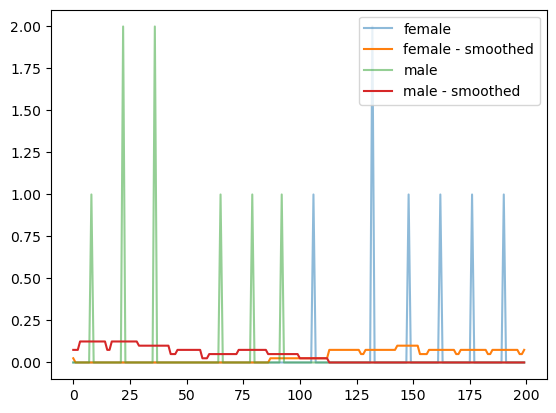

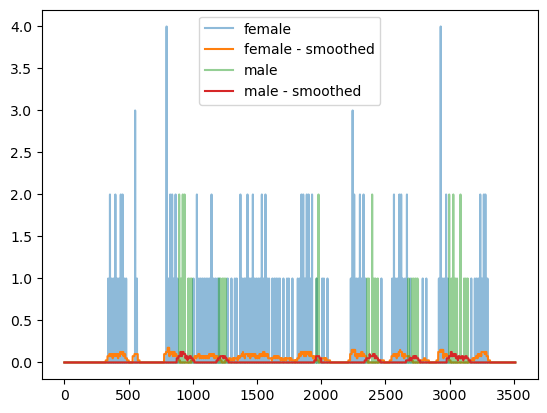

In [9]:
plt.plot(pheno[0,900:1100,6], label='female', alpha=0.5)
plt.plot(pheno[0,900:1100,10],label ='female - smoothed')
plt.plot(pheno[0,900:1100,7], label='male', alpha=0.5)
plt.plot(pheno[0,900:1100,11],label='male - smoothed')
plt.legend()

plt.show()

plt.plot(pheno[0,:,6], label='female', alpha=0.5)
plt.plot(pheno[0,:,10], label ='female - smoothed')
plt.plot(pheno[0,:,7], label='male', alpha=0.5)
plt.plot(pheno[0,:,11], label='male - smoothed')
plt.legend()

plt.show()

In [10]:
class RandomForestDataset():
    def __init__(self,meteo_data: pd.DataFrame,pheno_data: Sequence[pd.DataFrame]) -> None:
        """
        !!! CAN BE MADE WAY FASTER WITH NUMPY!!!
        Function which initializes the dataset for the Random Forest
        Args:
        meteo_data: pd.DataFrame, the meteorological data
        pheno_data: Sequence[pd.DataFrame], the phenological data
        
        Returns:
        self
        """
        self.data = np.concatenate([np.concatenate([meteo_data,pheno],axis=-1).reshape(1,-1,21) for pheno in pheno_data], axis=0, dtype=np.float32)

    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self,tree:int) -> Sequence[pd.DataFrame]:
        return self.data[tree]
    
    def get_dataset(self,start_date, end_date, prediction_start, random_sample:int=None) -> pd.DataFrame:
        """
        Function which retrieves the dataset from the given start and end date for the data X
        and the prediction_start and prediction_end for the prediction y.
        The dates give the relative distance and keep it for every sample.
        Random samples can be taken from the dataset.

        Example: 
        start_date=0, end_date=100, prediction_start=100, prediction_end=101
        The data X is 100 days and the prediction y is 1 day irrespective if the start day is 
        0 -> 100, 
        200 -> 300, 
        217 -> 317 
        etc.
        ...

        Args:
        start_date: int, the start date of the data X in days starting from 0
        end_date: int, the end date of the data X in days

        #between end_date and prediction_start can be a gap

        prediction_start: int, the start date of the prediction y in days
        prediction_end: int, the end date of the prediction y in days

        random_sample: int, the number of random samples to be taken from the dataset

        Returns:
        X_dataset: pd.DataFrame, the data X dataset
        y_dataset: pd.Series, the prediction y dataset
        """

        input_time = end_date-start_date
        gap = prediction_start-start_date
        prediction_time = prediction_start-start_date+1

        sample_X, sample_y = self.get_sample(0, input_time, gap)
        print(sample_X.shape, sample_y.shape)
        assert len(sample_X.shape) == 2, "X needs to be 2D"
        X_dataset = np.zeros(((self.data.shape[1]-prediction_time+1)*sample_X.shape[0],sample_X.shape[-1]),dtype=np.float32)
        print(X_dataset.shape)
        y_dataset = np.zeros(((self.data.shape[1]-prediction_time+1)*sample_y.shape[0]),dtype=np.float32)
        print(y_dataset.shape)


        for day in range(0,self.data.shape[1]-prediction_time+1):
            X, y = self.get_sample(day,day+input_time,day+gap)

            X_dataset[day*sample_X.shape[0]:day*sample_X.shape[0]+sample_X.shape[0]] = X.astype(np.float32)
            y_dataset[day*sample_y.shape[0]:day*sample_y.shape[0]+sample_y.shape[0]] = y.astype(np.float32)
            print(f'{day+1} of {self.data.shape[1]-prediction_time+1}', end='\r')


        return X_dataset, y_dataset
    
    def get_sample(self,start_date: int, end_date: int, prediction_start: int, tree: int=None) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Function which retrieves one sample from the dataset with the given start and end date for the data X 
        and the prediction_start and prediction_end for the prediction y.
        Exact dates in the data.

        Args:
        start_date: int, the start date of the data X in days starting from 0 
        end_date: int, the end date of the data X in days

        #between end_date and prediction_start can be a gap

        prediction_start: int, the start date of the prediction y in days
        prediction_end: int, the end date of the prediction y in days

        tree: int, the tree from which the sample should be retrieved

        Returns:
        X: pd.DataFrame, the data X sample
        y: pd.Series, the prediction y sample
        """
        prediction_end = prediction_start+1 #if prediction_start==prediction_end else NotImplementedError('The prediction_end must be one day after the prediction_start not yet implemented. Or sum up the days in the prediction_start')
        if tree is not None:
            X = self.retrieve_variables(self.data[tree,start_date:end_date,:])
            y = self.one_hot_encoding_flowers(self.data[tree, prediction_start:prediction_end,19:21])
            
        else:
            X = self.retrieve_variables(self.data[:,start_date:end_date,:])
            y = self.one_hot_encoding_flowers(self.data[:, prediction_start:prediction_end,19:21]) #daily
        
        return X, y
    
    def retrieve_variables(self,X:np.array) -> np.array:
        """
        Function which determines the INPUT variables of X sample-wise for the Random Forest

            Args:
            X: pd.DataFrame, the orginal data to be transformed

            Returns:
        """
        return X
    
    def one_hot_encoding_flowers(self,y:np.array) -> np.array:
        """
        Function which one-hot encodes the flowers for the Random Forest
        Args: 
        y: pd.DataFrame, the orginal data to be transformed
        
        Returns:
        pd.Series, the transformed data as classes"""

        y = y.squeeze(axis=1) if len(y.shape) > 2 else y
        female = y[:,0]
        male = y[:,1]

        ohe_flowers = np.zeros((y.shape[0]))

        for i, (f,m) in enumerate(zip(female,male)):
            if f > m:
                ohe_flowers[i] = 1
            elif f < m:
                ohe_flowers[i] = 2
            elif f == m and f == 0:
                ohe_flowers[i] = 3
            else:
                ohe_flowers[i] = 4
        return ohe_flowers


In [11]:
class RandomForestDatasetQuantile(RandomForestDataset):
    def retrieve_variables(self,X:np.array) -> pd.Series:
        """
        {
        0: 'TMin', 1: 'TMax', 2: 'TAverage', 
        3: 'HRMin', 4: 'HRMax', 5: 'HRAverage', 
        6: 'WindSpeed', 7: 'Rainfall', 8: 'Rg',
        9: 'RankOneLeafDate', 10: 'AppearedSpatheDate_compl', 
        11: 'OpenedSpatheDate_compl', 12: 'FloweringDate_compl', 
        13: 'HarvestDate_compl', 14: 'BunchMass', 
        15: 'FemaleInflo', 16: 'MaleInflo', 17: 'AbortedInflo', 
        18: 'BunchLoad', 19: 'FemaleInflo_r', 20: 'MaleInflo_r'}

        }
        """
        #shape(trees,timeperiods)
        
        if len(X.shape) == 2:
            X_out = np.zeros((int(X.shape[0]/100),4,9), dtype=np.float32)
            X_out_two = np.zeros((int(X.shape[0]/100),2), dtype=np.float32)
            for tf, time in enumerate(range(0,X.shape[0],100)):
                #print(time)
                for feat in range(9):
                    #print(feat)
                    for quant in range(4):
                        #print(quant)
                        if quant < 2:
                            X_out[tf, quant, feat] = np.sum(np.where(X[time:time+101,feat] <= extreme_quantiles[quant,feat],1,0),axis=0)
                        else:
                            X_out[tf, quant, feat] = np.sum(np.where(X[time:time+101,feat] >= extreme_quantiles[quant,feat],1,0),axis=0)
                for i, feat_2 in enumerate([15,16]):
                    X_out_two[tf,i] = np.sum(X[time:time+101,feat_2],axis=0)
                    
            return np.concatenate((X_out.reshape(-1), X_out_two.reshape(-1)),axis=-1)
        
        else:
            X_out = np.zeros((self.data.shape[0],int(X.shape[1]/100),4,9), dtype=np.float32)
            X_out_two = np.zeros((self.data.shape[0],int(X.shape[1]/100),2), dtype=np.float32)
            for tf, time in enumerate(range(0,X.shape[1],100)):
                #print(time)
                for feat in range(9):
                    #print(feat)
                    for quant in range(4):
                        #print(quant)
                        if quant < 2:
                            X_out[:,tf, quant, feat] = np.sum(np.where(X[:,time:time+101,feat] <= extreme_quantiles[quant,feat],1,0),axis=1)
                        else:
                            X_out[:,tf, quant, feat] = np.sum(np.where(X[:,time:time+101,feat] >= extreme_quantiles[quant,feat],1,0),axis=1)
                for i, feat_2 in enumerate([15,16]):
                    X_out_two[:,tf,i] = np.sum(X[:,time:time+101,feat_2],axis=1) 

            return np.concatenate((X_out.reshape(self.data.shape[0],-1),X_out_two.reshape(self.data.shape[0],-1)),axis=-1)

In [12]:
dataset = RandomForestDatasetQuantile(meteo_data=meteo,pheno_data=pheno)

In [13]:
d = dataset.get_dataset(0, 700, 1000)
print(np.unique(d[1], return_counts=True))

(266, 266) (266,)
(668458, 266)
(668458,)
(array([1., 2., 3., 4.], dtype=float32), array([284548, 158520, 201659,  23731]))


# Check the X inputs highs & add pheno data

In [14]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(d[0],d[1],test_size=0.1)

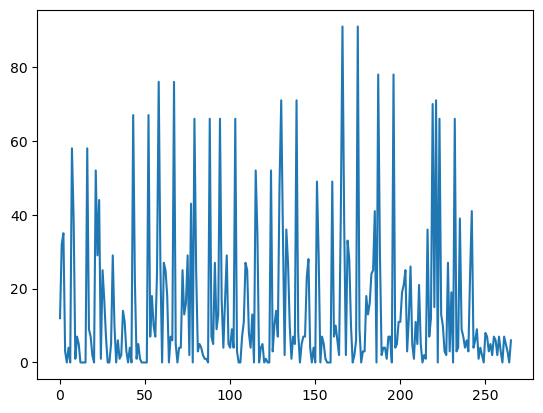

In [15]:
plt.plot(x_train[50000])
plt.show()

In [16]:
ids = np.where(y_train != 4)[0]
print(ids.shape)

x_train_adapted = x_train[ids,:]
y_train_adapted = y_train[ids]

ids = np.where(y_test != 4)[0]

x_test_adapted = x_test[ids,:]
y_test_adapted = y_test[ids]

(580360,)


In [17]:
def upsample_dataset(X: np.ndarray, y: np.ndarray):
    """
    Upsamples the minority classes in the dataset to balance the class distribution.

    Args:
        X (np.ndarray): Feature matrix of shape (n_samples, n_features).
        y (np.ndarray): Label array of shape (n_samples,) or (n_samples, 1).

    Returns:
        X_resampled (np.ndarray): Upsampled feature matrix.
        y_resampled (np.ndarray): Upsampled label array.
    """
    # Flatten y to ensure it's 1D
    y = y.ravel()
    
    # Find unique classes and their counts
    classes, counts = np.unique(y, return_counts=True)
    print(f"Original class distribution:\nClasses: {classes}\nCounts: {counts}\n")

    # Determine the maximum class count
    max_count = counts.max()
    class_counts = dict(zip(classes, counts))
    print(f"Majority class count: {max_count}")

    # Separate data by class
    X_resampled = []
    y_resampled = []
    for cls in classes:
        idx = np.where(y == cls)[0]
        X_cls = X[idx]
        y_cls = y[idx]
        n_samples_needed = max_count - class_counts[cls]

        if n_samples_needed > 0:
            # Upsample the minority class
            indices_to_duplicate = np.random.choice(idx, size=n_samples_needed, replace=True)
            X_upsampled = X[indices_to_duplicate]
            y_upsampled = y[indices_to_duplicate]

            # Combine the original and upsampled data
            X_cls = np.vstack((X_cls, X_upsampled))
            y_cls = np.hstack((y_cls, y_upsampled))
            print(f"Upsampled class {cls} from {class_counts[cls]} to {len(y_cls)} samples.")
        else:
            print(f"Class {cls} does not need upsampling.")

        X_resampled.append(X_cls)
        y_resampled.append(y_cls)

    # Concatenate all classes back into single arrays
    X_resampled = np.vstack(X_resampled)
    y_resampled = np.hstack(y_resampled)

    # Shuffle the dataset to mix the upsampled data
    permuted_indices = np.random.permutation(len(y_resampled))
    X_resampled = X_resampled[permuted_indices]
    y_resampled = y_resampled[permuted_indices]

    # Verify the new class distribution
    new_classes, new_counts = np.unique(y_resampled, return_counts=True)
    print(f"\nResampled class distribution:\nClasses: {new_classes}\nCounts: {new_counts}")

    return X_resampled, y_resampled

x_train_adapted, y_train_adapted = upsample_dataset(x_train_adapted, y_train_adapted)

Original class distribution:
Classes: [1. 2. 3.]
Counts: [256225 142727 181408]

Majority class count: 256225
Class 1.0 does not need upsampling.
Upsampled class 2.0 from 142727 to 256225 samples.
Upsampled class 3.0 from 181408 to 256225 samples.

Resampled class distribution:
Classes: [1. 2. 3.]
Counts: [256225 256225 256225]


In [18]:
x_test_adapted.shape

(64367, 266)

In [19]:
from sklearn.model_selection import GridSearchCV
from random import randint
"""
param_grid = {
    'n_estimators': [randint(100,1000) for n_3 in range(10)],
    'max_depth': [randint(5,100) for n_4 in range(10)]+[None],
    'min_samples_split': [randint(5,100) for n_1 in range(10)],
    'min_samples_leaf': [randint(5,100) for n_2 in range(10)]
}

rfc = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
grid_search.fit(x_train_adapted, y_train_adapted.values.reshape(-1))
"""

"\nparam_grid = {\n    'n_estimators': [randint(100,1000) for n_3 in range(10)],\n    'max_depth': [randint(5,100) for n_4 in range(10)]+[None],\n    'min_samples_split': [randint(5,100) for n_1 in range(10)],\n    'min_samples_leaf': [randint(5,100) for n_2 in range(10)]\n}\n\nrfc = RandomForestClassifier()\ngrid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)\ngrid_search.fit(x_train_adapted, y_train_adapted.values.reshape(-1))\n"

In [20]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=None, max_features='sqrt')
rfc.fit(x_train_adapted, y_train_adapted)

RandomForestClassifier(n_estimators=300)

0.8700887100532881
0.9963768822974599


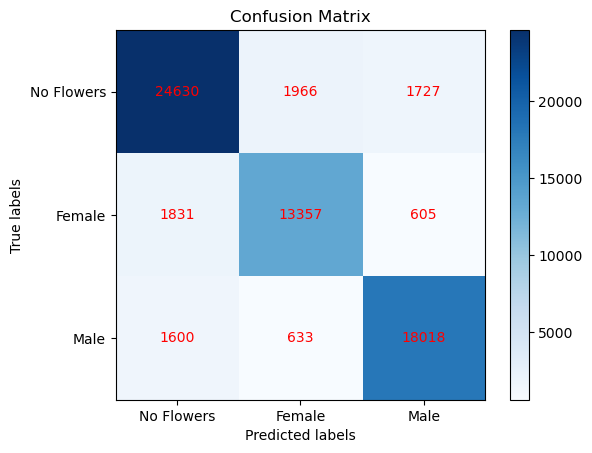

In [21]:
predict = rfc.predict(x_test_adapted)
print(rfc.score(x_test_adapted,y_test_adapted))
print(rfc.score(x_train_adapted,y_train_adapted))

confusion_matrix = sklearn.metrics.confusion_matrix(y_test_adapted, predict)


# Plot the confusion matrix with values
plt.imshow(confusion_matrix, cmap='Blues', interpolation='None')
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels for axes
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.xticks([0, 1, 2], ['No Flowers', 'Female', 'Male'])
plt.yticks([0, 1, 2], ['No Flowers', 'Female', 'Male'])

# Add the numeric values inside the confusion matrix
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='red')

plt.show()



In [22]:
df = pd.DataFrame({'Actual': y_test_adapted, 'Predicted': predict})
print(df)
df.to_csv('RFPrediction_extremeEvents_malefemale__ConfusionMatrix.csv',index=False)

       Actual  Predicted
0         1.0        1.0
1         2.0        2.0
2         1.0        1.0
3         1.0        1.0
4         1.0        1.0
...       ...        ...
64362     1.0        1.0
64363     1.0        1.0
64364     3.0        3.0
64365     2.0        2.0
64366     2.0        1.0

[64367 rows x 2 columns]


In [24]:
import random

def generate_random_list():
    random.seed(44)
    return [random.randint(0, 265) for _ in range(50)]

# Example usage:
random_list = generate_random_list()
print(random_list)

[209, 59, 90, 194, 115, 148, 14, 115, 59, 4, 51, 80, 263, 155, 193, 207, 166, 183, 37, 173, 144, 81, 57, 261, 35, 48, 138, 161, 55, 148, 17, 176, 197, 49, 244, 243, 97, 96, 66, 132, 126, 25, 22, 223, 19, 168, 189, 241, 232, 77]


In [25]:

predicted = []
real = []
tree = []
days = []

for t in random_list:
    print(f'\nTree: {t}')
    for day in range(0,2500):
        print(f'Day: {day}', end='\r')
        datapoint = dataset.get_sample(day,700+day,1000+day,t)
        if datapoint[1] == 4:
            continue
        predicted.append(rfc.predict(datapoint[0].reshape(1,-1))[0])
        real.append(datapoint[1][0])
        tree.append(t)
        days.append(day)

    # print(len(predicted))
    # plt.plot(range(100), real, label='real', alpha=0.5)
    # plt.scatter(range(100), real, label='real',s=10)
    # plt.scatter(range(100), predicted, label='predicted', marker='x',s=70)
    # plt.legend()
    # plt.show()

df_2 = pd.DataFrame({'Actual': real, 'Predicted': predicted, 'Tree': tree, 'Day': days})
df_2.to_csv('RFPrediction_extremeEvents_malefemale_50Samples.csv', index=False)


Tree: 209
Day: 2499
Tree: 59
Day: 2499
Tree: 90
Day: 2499
Tree: 194
Day: 2499
Tree: 115
Day: 2499
Tree: 148
Day: 2499
Tree: 14
Day: 2499
Tree: 115
Day: 2499
Tree: 59
Day: 2499
Tree: 4
Day: 2499
Tree: 51
Day: 2499
Tree: 80
Day: 2499
Tree: 263
Day: 2499
Tree: 155
Day: 2499
Tree: 193
Day: 2499
Tree: 207
Day: 2499
Tree: 166


KeyboardInterrupt: 

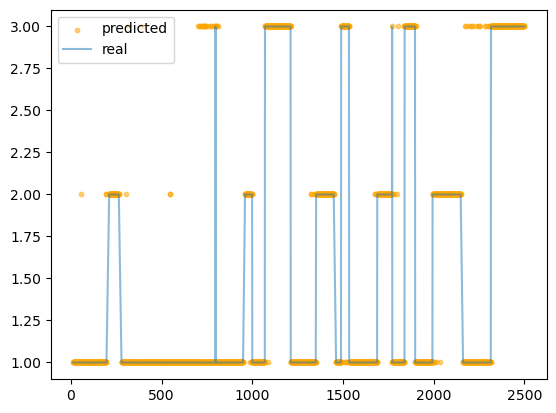

In [140]:
'''pltin = df_2[df_2['Tree'] == 0]
plt.scatter(pltin['Day'], pltin['Predicted'], label='predicted', c='orange', alpha=0.5, s=10)
plt.plot(pltin['Day'], pltin['Actual'], label='real', alpha=0.5)
plt.legend()
plt.show()'''


0.6086956521739131
0.6115629808749176


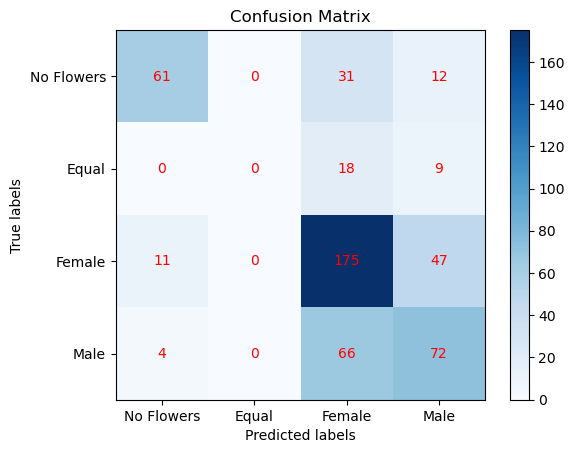

['HRAverage_500_higher_96.39']
['HRAverage_400_lower_79.5']
['HRAverage_600_lower_79.5']
['TAverage_300_higher_27.5']
['HRAverage_100_higher_87.96']
------------------------------------------
['HRAverage_100_higher_96.39']
['HRAverage_600_lower_79.5']
['TAverage_0_higher_28.8']
['HRAverage_0_lower_79.5']
['TAverage_0_lower_26.3']


In [95]:
'''
rfc1 = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_leaf=1, min_samples_split=10, max_features='sqrt')
rfc1.fit(x_train, y_train.values.reshape(-1))

predict = rfc1.predict(x_test)
print(rfc1.score(x_test,y_test))
print(rfc1.score(x_train,y_train))

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, predict)

# Plot the confusion matrix with values
plt.imshow(confusion_matrix, cmap='Blues', interpolation='None')
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels for axes
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.xticks([0, 1, 2, 3], ['No Flowers', 'Equal', 'Female', 'Male'])
plt.yticks([0, 1, 2, 3], ['No Flowers', 'Equal', 'Female', 'Male'])

# Add the numeric values inside the confusion matrix
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='red')

plt.show()

cols = {}

for i, feature in enumerate(x_train.columns):
    cols[i] = [feature]


for f in rfc1.estimators_[0].tree_.feature[:5]:
    try:
        print(cols[f])
    except:
        continue
print('------------------------------------------')
for f in rfc1.estimators_[1].tree_.feature[:5]:
    try:
        print(cols[f])
    except:
        continue
'''